## Problem Statement

You can download train and test dataset from [here](https://drive.google.com/drive/folders/1F2PjpJ_u_iaD-Fs0wwcymRiVVLK34-Fu). This dataset has 4 classes. Labels for
training data are provided, you have to submit labels of test data. Feel free to use any Machine
learning or Deep learning technique.

### Imports

In this notebook, there is going to be lot of experimentation, hence, instead of building everything from scratch, it is better to make use of freely available and highly optimized Python libraries. In particular, 
* [Numpy](http://www.numpy.org/) will be used for powerful matrix and scientific operations. 
* [Pandas](https://pandas.pydata.org/) for data transformation and analysis. 
* [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) for data visualization.
* [Scikit-learn](https://scikit-learn.org/stable/) to use machine learning classifiers, splitting data and metrics for evaluation.
* [Keras](https://keras.io/) to build deep learning based classifiers.

In [1]:
#standard utilities
import os
import pickle #to load pickle data
from collections import Counter

#data science and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, accuracy_score, 
                             confusion_matrix)  

#deep learning library
import keras
from keras.models import Sequential, load_model
from keras.layers import (Conv2D, MaxPooling2D, 
                          Dense, Flatten, 
                          Dropout, BatchNormalization)
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

% matplotlib inline

C:\Users\Akshay\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Main directory path for all the files
PATH = r'..\CV_problem'

In [5]:
os.listdir(PATH)

['.ipynb_checkpoints', 'Computer vision problem.ipynb', 'Data', 'Models']

### Data Loading and Visualization

Data has been provided in pickle format, hence, first step will be to load in the pickle file which can be easily done in 2 lines as shown in the following cell.

In [4]:
with open(f'{PATH}\\Data\\train_image.pkl', 'rb') as image_file:
    train_images = pickle.load(image_file)

Let us look at the amount of data we have for training the classification models.

In [4]:
print(f"Number of training samples: {len(train_images)}")

Number of training samples: 8000


In [5]:
train_labels = np.array(np.load(f'{PATH}\\Data\\train_label.pkl', allow_pickle=True))

In [6]:
Counter(train_labels)

Counter({0: 2000, 2: 2000, 3: 2000, 6: 2000})

So, in this dataset, we have 2000 training samples corresponding to each of the 4 classes: 0, 2, 3 and 6, hence, in total we have 8000 number of images for training. As all the classes are equally distributed, our dataset is perfectly balanced and doesn't need any kind of oversampling or undersampling.<br>
Now, lets have look at some of the images from our training data. Before, plotting we will first convert the list: `train_images` to a `numpy` array.

2D image is nothing but a 2D matrix where each element is the value of a pixel at a particular position. So, before moving on to processing the data, it is better to convert the images into  numpy arrays which will help a lot in performing matrix operations in a much faster way.

In [7]:
train_images = np.array(train_images)

In [8]:
print(f"Shape of train_images: {train_images.shape}")

Shape of train_images: (8000, 784)


We already now that 8000 is the number of training samples. We can conclude from shape of the `train_images` that each image has been represented by a vector of length 784. So, its very much likely that each of the images were initially of size: 28 X 28 pixels and have been flattened to 28\*28 i.e. 784 length of vector. Let's see if our inference is correct by plotting the samples by reshaping them to a size of 28 X 28. Below is the function, `plot_multiple_data()` that will plot `n_rows*n_columns` number of images simultaneously.

In [9]:
def plot_multiple_data(n_rows, n_columns, indices):
    '''
    Parameters-
        n_rows, n_columns: Number of rows and columns in the figure
        indices: List of indices for the images from the dataset
    '''
    #figure that will be displayed
    fig = plt.figure(figsize=(n_rows*2, n_columns*2))

    #Showing first n_rows*n_columns images from the dataset specified by indices
    for i in range(1, n_rows*n_columns + 1):
        plt.subplot(n_rows, n_columns, i)
        plt.imshow(train_images[indices[i]].reshape(28, 28))
        plt.title(f'Label: {train_labels[indices[i]]}') #corresponding label to each of the image
    fig.tight_layout()  #for better padding amongst subplots
    plt.show()

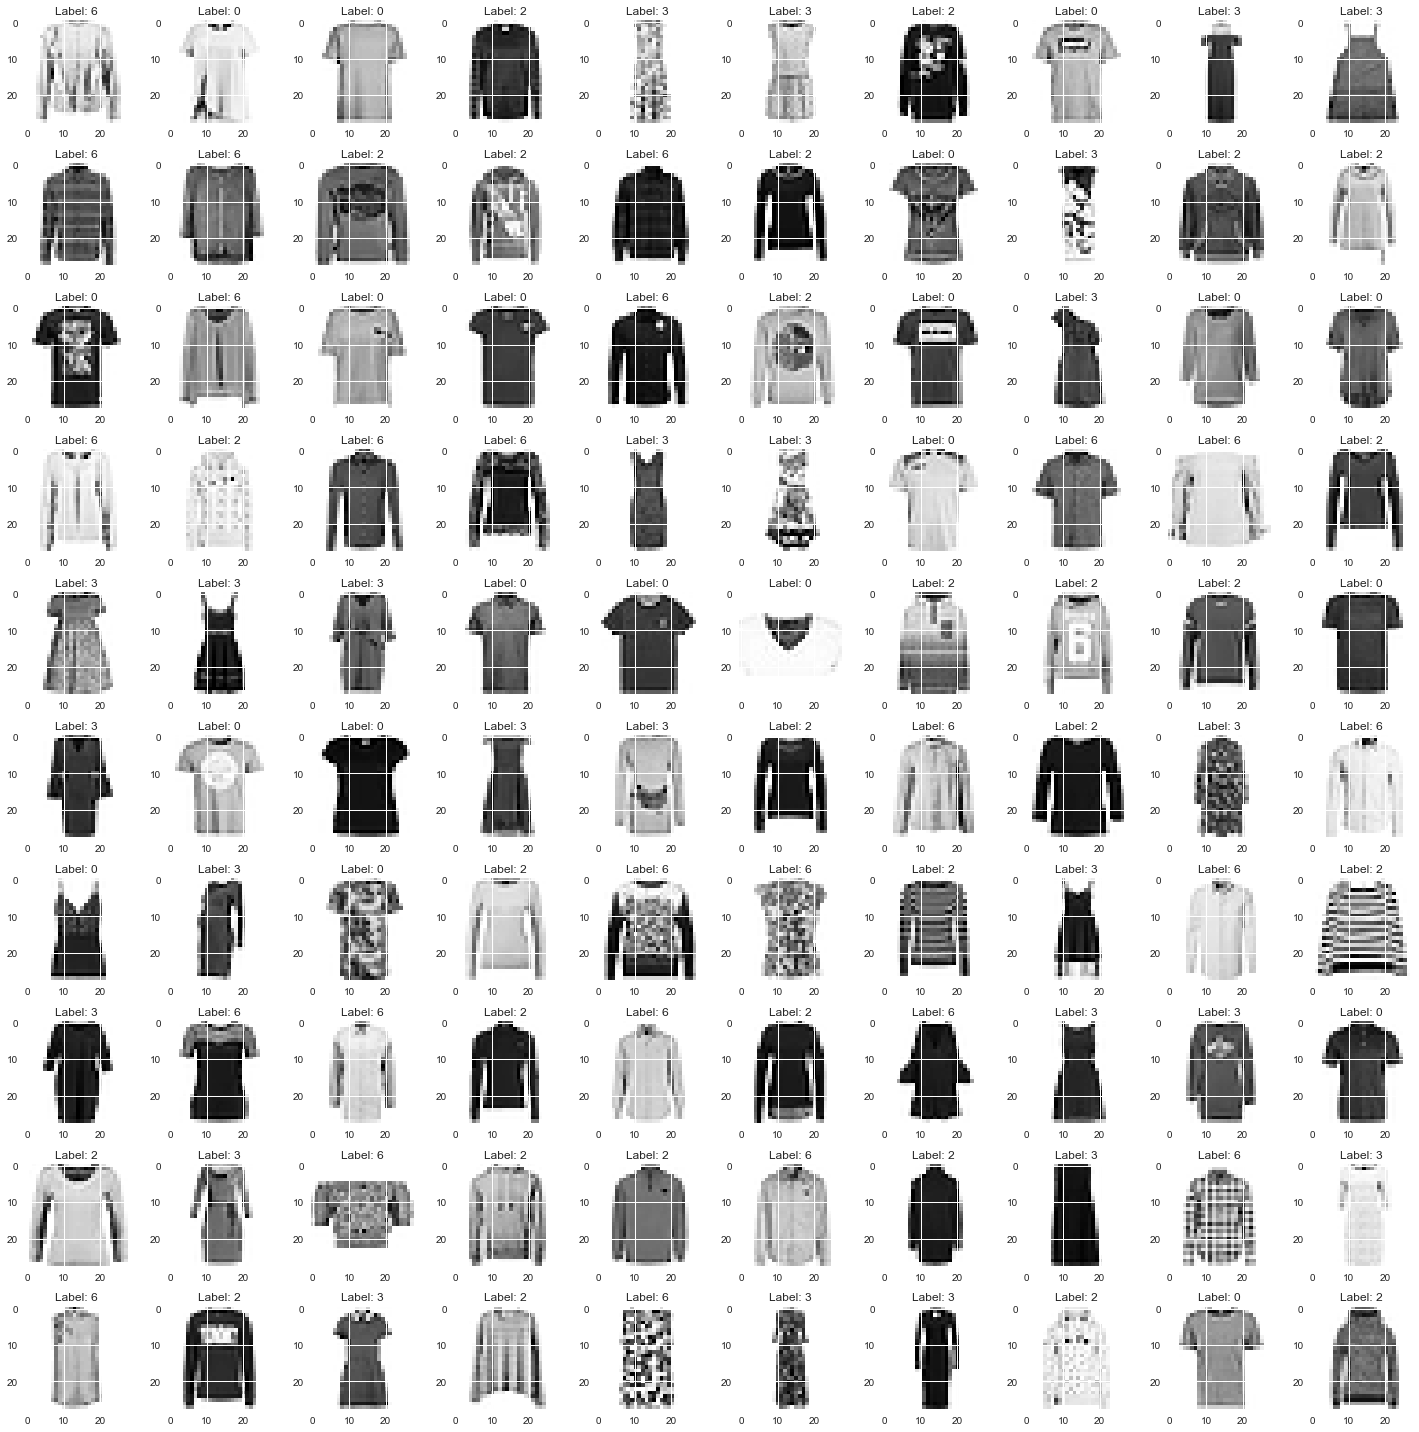

In [10]:
random_indices = np.random.permutation(train_images.shape[0]) #generate random indices for plotting
plot_multiple_data(10, 10, random_indices)

After seeing the above subplots, we can say that:
* Label 0 is for Half sleeve T-shirts/Tops
* Label 2 is for Long sleeve T-shirts or Pullovers
* Label 3 is for Dress
* Label 6 is for Shirts

Now, as we have gained some insights about the data, it will be better to start pre-processing the data.

### Data Pre-processing <a id='preprocessing'></a>


In [11]:
#setting random seed so that every time we run random, we get the same result
np.random.seed(42)

#### Splitting the available training data into train and validation sets

It is not appropriate to evaluate the classification model's performance on the same data it was trained upon. So, here, we will split the provided training data into two sets: Training and validation. Here, we'll use `scikit-learn`'s `train_test_split` to split the data into 90:10 ratio. 90% data is for training and rest of the 10% for validation.

In [44]:
Train_x, Val_x, Train_y, Val_y = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

In [13]:
print(f"Shape of Training features: {Train_x.shape}")
print(f"Shape of Training labels: {Train_y.shape}")
print(f"Shape of Validation features: {Val_x.shape}")
print(f"Shape of Validation labels: {Val_y.shape}")  

Shape of Training features: (7200, 784)
Shape of Training labels: (7200,)
Shape of Validation features: (800, 784)
Shape of Validation labels: (800,)


#### Pre-processing for CNN classifier

Convolution Neural Networks (CNN) require images to be in 2D shape while in our case each image is a vector of 784 length. The vector form will work with other machine learning algorithms. Other than reshaping the representation of images, two more steps have to be performed for CNN, that are normalizing and one-hot encoding of labels. Hence, the following pre-processing steps are exclusive to CNN  based classifier. 

##### Reshaping the Train_x and Val_x 

Following function, `reshape_vector` will take in the datasets with images in the vector form and will return datasets with reshaped representation of images. Each of the image will be represented by a matrix of shape, 28 x 28 x 1. Since the images are black and white, 3rd dimension is equal to 1. 

In [14]:
def reshape_vector(Train_x, Val_x):
    '''
    Parameters-
        Train_x, Val_x: Training and validation sets with images as vector array
    Returns-
        Reshaped Train_x and Val_x 
    '''
    return Train_x.reshape((-1, 28, 28, 1)), Val_x.reshape((-1, 28, 28, 1))

##### Normalizing by scaling down pixel values to the range [0, 1]

Range of pixel values is 0 to 255. If we normalize the pixel values to a smaller range of 0 to 1, the model will be able to learn the real structures instead of dealing with the scale differences. By doing so, learning agent can get stable gradient feedbacks avoiding scale differences of different dimensions. This provides faster learning and eventually leds to a better minima.

In [15]:
def normalize(Train_x, Val_x): 
    '''
    Parameters-
        Train_x, Val_x: Reshaped Train_x and Val_x
    Returns-
        Normalized Train_x and Val_x
    
    '''
    return Train_x.astype("float32") / 255.0, Val_x.astype("float32") / 255.0

##### One-hot encoding Labels

Later in the notebook, CNN classifier instead of directly outputting one of the classes, it will be outputting probabilities corresponding to each class. So, the output will always be in the range: [0, 1]. As, in our case, labels are 0, 2, 3 and 6, it is required to transform these labels and represent them in the form of 0 and 1. This transformation is nothing but one-hot encoding. <br>
Here `pandas`' `get_dummies` method will come in handy that will easily transorm the data in required encoded form.

In [16]:
def one_hot_encode(Train_y, Val_y):
    '''
    Parameters-
        Train_y, Val_y = Array of labels
    Returns-
        One-hot encoded labels
    '''
    return pd.get_dummies(Train_y), pd.get_dummies(Val_y)

### Classification 

Now, as we are done with all the pre-processing, we can start trying machine learning algorithms and choose the one which outperforms all of the other ones.

#### 1. Using K-Nearest Neighbors Classifier

K-Nearest neighbors algorithm is amongst the simplest machine learning algorithms which can be used both for classification as well as regression problems (most of the times for classification).  Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. In scikit-learn's implementation, number of nearest neighbors is assigned by parameter, `n_neighbors`. Here, we'll use `n_neighbors` = 3. <br>
Training data can be easily trained using this classifier by using `fit()` method on classifier's instance.

In [17]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(Train_x, Train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

Let's see how much accurate our model is in distinguishing amongst 4 classes.

In [18]:
neigh_predictions = neigh.predict(Val_x)

In [19]:
neigh_accuracy = accuracy_score(Val_y, neigh_predictions)
print(f'Accuracy score of KNN Classifier: {neigh_accuracy}')

Accuracy score of KNN Classifier: 0.78


78% accuracy is reasonably good considering simplicity of algorithm and minimal parameter tuning. Let's look at how many samples from validation set were correctly predicted by plotting the confusion matrix. Again, we can easily get the values for confusion matrix using `scikit-learn` and it can then be plotted using `matplotlib` and `seaborn`.

In [30]:
def plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Parameters-
        y_true: Array of true labels
        y_pred: Array of predicted labels
        labels: List of labels ([0, 2, 3, 6])
    '''
    cm = confusion_matrix(y_true, y_pred)
    
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g'); #annot=True to annotate cells, fmt='g' to sho

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1])

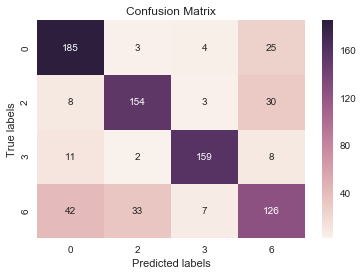

In [57]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, neigh_predictions, labels)

From above plot we can make the following conclusions:
* Out of 217 samples that have label 0, 185 have been predicted correctly. 
* There are 25 samples whose actual label is 0, but were predicted as 6.
* Similarly 30 samples with actual label as 2 are predicted 6.
* Out of 208 samples that have label 6, 42 are predicted as 0, 33 are predicted as 2 and 7 are predicted 3.
So, the model is mostly getting confused due to label 6. Let's look at some more metrics by generating classification report to get much clearer view at the results.

In [20]:
neigh_classification_report = classification_report(Val_y, neigh_predictions)
print(f'Classification report of KNN Classifier: \n{neigh_classification_report}')

Classification report of KNN Classifier: 
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       217
           2       0.80      0.79      0.80       195
           3       0.92      0.88      0.90       180
           6       0.67      0.61      0.63       208

   micro avg       0.78      0.78      0.78       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.78      0.78      0.78       800



Clearly, precision, recall and f1-score is lowest when it comes to class label 6.

#### 2. Using Random Forest Classifier

Second classifier that we'll be using is Random Forest Classifier. This classifier is an ensemble of multiple decision trees that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.<br>
In below cell, we've defined three parameters and rest are kept as default. `criterion` is the function to measure the quality of a split. Here it is set to `entropy` is for information gain that is computed using logarithmics. `max_depth` is the maximum depth for the decision trees in the forest. `n_estimators` is the number of trees to be used, usually the more, the better.<br>
Same steps that were followed for KNN classifier will be followed here too.

In [64]:
forest = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=100)
forest.fit(Train_x, Train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
forest_predictions = forest.predict(Val_x)

In [66]:
forest_accuracy = accuracy_score(Val_y, forest_predictions)
print(f'Accuracy score of Random Forest Classifier: {forest_accuracy}')

Accuracy score of Random Forest Classifier: 0.8175


Random forest classifier is certainly more accurate than KNN classifier. Let's see if it is able to correctly predict label 6 this time.

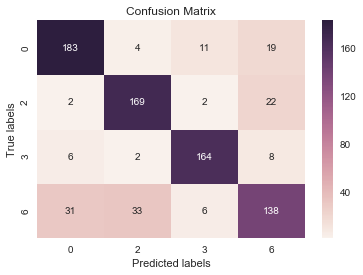

In [67]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, forest_predictions, labels)

Well, this time too classifier performs most poorly for label 6, but there certainly is significant improvement, if we look at number of correctly predicted labels.

In [68]:
forest_classification_report = classification_report(Val_y, forest_predictions)
print(f'Classification report of Random Forest Classifier: \n{forest_classification_report}')

Classification report of Random Forest Classifier: 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       217
           2       0.81      0.87      0.84       195
           3       0.90      0.91      0.90       180
           6       0.74      0.66      0.70       208

   micro avg       0.82      0.82      0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800



#### 3. Using Support Vector Classifier

Before moving on to CNNs, that are meant to outperform other algorithms when it comes to computer vision problems, we'll give a shot to one more popular classification algorithm i.e. Support Vector Machine Classifier. The idea of SVM classifier can be simply put as: The algorithm creates a line or a hyperplane which separates the data into classes.<br>
Here, `scikit-learn`'s implementation SVC will be use for building the classifier. Specified parameters are: `C` which is a penalty parameter `C` of the error term, `kernel` is set to `poly` as the data is unstructured. `gamma` is the coefficient for kernel set to `auto` hence coefficient will be `1\n_features`.

In [69]:
svc = SVC(C=10, kernel='poly', gamma='auto')
svc.fit(Train_x, Train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
svc_predictions = svc.predict(Val_x)

In [71]:
svc_accuracy = accuracy_score(Val_y, svc_predictions)
print(f'Accuracy score of Support Vector Classifier: {svc_accuracy}')

Accuracy score of Support Vector Classifier: 0.805


We are down on accuracy by about 1%. Let's look at confusion matrix and classification report.

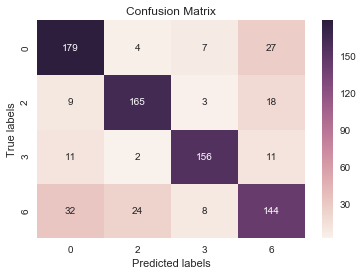

In [72]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Val_y, svc_predictions, labels)

In [73]:
svc_classification_report = classification_report(Val_y, svc_predictions)
print(f'Classification report of Support Vector Classifier: \n{svc_classification_report}')

Classification report of Support Vector Classifier: 
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       217
           2       0.85      0.85      0.85       195
           3       0.90      0.87      0.88       180
           6       0.72      0.69      0.71       208

   micro avg       0.81      0.81      0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.80       800



SVC performs equally good as Random forest classifier (some what poorer). At this point, we'vepretty much tried most used machine learning algorithms and should move on to much more complex, deep learning algorithm, CNN.

#### 4. Using Convolutional Neural Networks

CNNs, like artificial neural networks (ANNs), are made up of neurons with learnable weights and biases. Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and responds with an output. The whole network has a loss function and that is minimized using optimizer functions. <br>
Main advantage of CNNs over ANNs and other machine learning algorithms is that these operate over volumes. That is also the reason, we'll have to reshape the image vectors into 2D forms. <br>
Now, we'll call the pre-processing functions that were exclusively defined for CNNs earlier in the [Data Pre-processing](#preprocessing) section.

In [45]:
Train_x, Val_x = reshape_vector(Train_x, Val_x)
Train_x, Val_x = normalize(Train_x, Val_x)
Train_y, Val_y = one_hot_encode(Train_y, Val_y)

After running the above, we're all set to build the CNN model. Here, we'll use `Keras`' [Sequential API](https://keras.io/models/sequential/). Using this, model can be considered as a linear stack of layers, added one after other in sequential manner.<br> We'll keep tuning the parameters until the result recieved is reasonable. One thing, that is most important to account for is Overfitting, hence, we'll monitor the validation accuracy of the models at each epoch.

##### Model 1

First CNN model will be consisting of following layers:
* [Conv2D](https://keras.io/layers/convolutional/): This layer create `filter` number of convolution kernels of size specified by `kernel_size` that are convolved with the layer input to produce a tensor of outputs activated by activation function specified by `activation` parameter. <br>Here, we'll use 5 `Conv2D` layers, each having `kernel_size` = 3. In sequential model we have to specify `input_shape` for very first layer and rest of the layers can make the inference about input by themselves.
* [MaxPooling2D](https://keras.io/layers/pooling/): This layer performs max pooling operation for spatial data. Basically, it downsamples the spatial dimension of input by a factor specified by `pool_size`. For instance, if `pool_size` = 2, spatial dimensions will be halved.<br> In our model, combination of `Conv2D` are followed by MaxPooling2D to occasionally reduce the size.
* [Dropout](https://keras.io/layers/core/): `Dropout` is one of the core layers that consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. This is usually called as regularization. <br> In this model, combination of `Conv2D` and `MaxPooling2D` are followed by `Dropout`. 
* [Flatten](https://keras.io/layers/core/): `Flatten` is another one of the core layers that flattens the input without affecting the batch size.
* [Dense](https://keras.io/layers/core/): Regular densely connected ANN layer with `activation` as `ReLU` for intermediate and `softmax` for final layer.

In [80]:
model = Sequential()

#feature extraction part
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (28,28,1), activation = 'relu')) #output: 26 x 26 x 32 
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')) #output: 24 x 24 x 32
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 12 x 12 x 32

model.add(Dropout(0.50)) #output: 12 x 12 x 32

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu')) #output: 10 x 10 x 64
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu')) #output: 8 x 8 x 64
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 4 x 4 x 64

model.add(Dropout(0.50)) #output: 4 x 4 x 64
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu')) #output: 2 x 2 x 32
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 1 x 1 x 32

#classification part
model.add(Flatten()) #output: 32
model.add(Dense(units = 32, activation = "relu")) #output: 32
model.add(Dense(units = 4, activation = "softmax")) #output: 4 (probabilites for each class)

Let's look at the summary for whole model by calling `summary()` method.

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
__________

So, in total we have 84, 644 parameters to be trained. For training these parameters, we'll have to specify a loss function, an optimizer for that loss function and metrics to evaluate the model during compilation step.<br> As we are using softmax function to get the outputs, we'll have to choose a loss function that will increase the probability for true classes. This can be done in best way using cross entropy loss function. Now, to minimize this loss function there are several optimizers available. Here, we'll use Adam optimizer. The name "Adam" is derived from adaptive moment estimation and have the following advantages as coined by its authors: 
* Straightforward to implement and computationally efficient.
* Invariant to diagonal rescale of the gradients.
* Well suited for problems that are large in terms of data and/or parameters.
* Appropriate for non-stationary objectives.
* Appropriate for problems with very noisy/or sparse gradients.
* Hyper-parameters have intuitive interpretation and typically require little tuning.<br>

Learning rate `lr` of the Adam is set to 0.001 which is also the default value.


In [82]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001), metrics =['accuracy'])

In [83]:
epochs = 25 #number of times training data will pass through model
batch_size=64 #number of training samples passed through model at a time
history = model.fit(Train_x, Train_y,
                     batch_size = batch_size,
                     epochs = epochs,
                     verbose = 2,
                     validation_data = (Val_x, Val_y))

Train on 7200 samples, validate on 800 samples
Epoch 1/25
 - 27s - loss: 1.0225 - acc: 0.5138 - val_loss: 0.8410 - val_acc: 0.6325
Epoch 2/25
 - 25s - loss: 0.7782 - acc: 0.6558 - val_loss: 0.6936 - val_acc: 0.7000
Epoch 3/25
 - 24s - loss: 0.6804 - acc: 0.7008 - val_loss: 0.6132 - val_acc: 0.7462
Epoch 4/25
 - 26s - loss: 0.6215 - acc: 0.7399 - val_loss: 0.5858 - val_acc: 0.7712
Epoch 5/25
 - 25s - loss: 0.5801 - acc: 0.7626 - val_loss: 0.5523 - val_acc: 0.7700
Epoch 6/25
 - 26s - loss: 0.5502 - acc: 0.7756 - val_loss: 0.5463 - val_acc: 0.7688
Epoch 7/25
 - 25s - loss: 0.5176 - acc: 0.7937 - val_loss: 0.5139 - val_acc: 0.7850
Epoch 8/25
 - 27s - loss: 0.5059 - acc: 0.7965 - val_loss: 0.5421 - val_acc: 0.7788
Epoch 9/25
 - 26s - loss: 0.4930 - acc: 0.8032 - val_loss: 0.4872 - val_acc: 0.8000
Epoch 10/25
 - 24s - loss: 0.4718 - acc: 0.8151 - val_loss: 0.4689 - val_acc: 0.7987
Epoch 11/25
 - 25s - loss: 0.4645 - acc: 0.8146 - val_loss: 0.4668 - val_acc: 0.8163
Epoch 12/25
 - 24s - loss: 

We've got straight 4% increase in the validation accuracy by using CNN. <br>

Now, let's compare the plots of loss values and accuracy values for training and validation sets. Keras provides the capability to register callbacks when training a model.
One of the default callbacks that is registered when training all models is the History callback. It records training metrics for each epoch. Hence, we can retrieve the loss and the accuracy values for training  as well as the validation set by this callback as shown below.

In [94]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

In [24]:
def plot_loss_acc(history, n_epochs):
    
    '''
    Parameters-
    history: Default Keras' callback which records training metrics
    n_epochs: Number of times data is passed through model during training
    '''
    
    #list to keep accuracy and loss values obtained during training and validation
    history_record = []
    
    #during training
    history_record.append(history.history['loss'])
    history_record.append(history.history['acc'])
    
    #during validation
    history_record.append(history.history['val_loss'])
    history_record.append(history.history['val_acc'])
    
    fig = plt.figure(figsize=(8, 4))
    
    #plotting two subplots
    #first subplot is for loss values
    #second for accuracy values
    for i in range(1, 3):
        
        plt.subplot(1, 2, i)
        plt.plot(np.arange(n_epochs), history_record[i - 1], label = "Training")
        plt.plot(np.arange(n_epochs), history_record[i + 1], label = "Validation")
        
        #axis labels
        plt.xlabel('Epochs')
        if(i % 2 != 0):
            plt.ylabel('Loss function values')
        else:
            plt.ylabel('Accuracy values')
        plt.legend()
        
    fig.tight_layout() #for better padding amongst subplots
    plt.show()
    

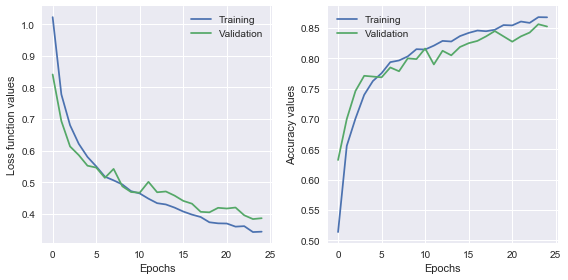

In [119]:
plot_loss_acc(history, 25)

In above figure, We can see the gradual decrease in the loss and increase in accuracy values for training as well as validation sets. Also, the difference between training accuracy and validation accuracy is ~1%, hence, our model is clearly not overfitting.<br>

Let's now generate predictions and evaluate this model with metrics that we also used above for machine learning algorithms.

In [131]:
predictions = model.predict(Val_x)

At this time, a particular prediction will look like:

In [132]:
model.predict(Val_x[0].reshape(1, 28, 28, 1))

array([[6.5609009e-04, 8.4759516e-01, 4.0542818e-05, 1.5170820e-01]],
      dtype=float32)

As the output of the model is supposed to be softmaxed vector of length = number of classes. Above predicted vector is nothing but the probabilitiy corresponding to each class. As value at the 2nd position or index 1 is maximum, hence, predicted class is the second class i.e. 2. <br>

In following cell, these predicted vectors are converted into corresponding class labels.

In [155]:
#dictionary mapping from indices of output vector to corresponding class labels
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}

#array to hold the predicted labels
CNN_predictions = np.zeros(len(predictions))

#loop through predicted vectors and adding predicted classes to CNN_predictions 
for i in range(len(predictions)):
    
    #get index of maximum element in vector
    arg_max = np.argmax(predictions[i])
    
    #add value of key: arg_max from prediction_dict to CNN_predictions
    CNN_predictions[i] = prediction_dict[arg_max]

As `Val_y` has also been converted to an array of one hot vectors. We'll have to decode them to original form.

In [159]:
#get index of maximum element in vector
Orig_Val_y = Val_y.values.argmax(axis=1)

Orig_Val_y = np.array([prediction_dict[y] for y in Orig_Val_y])

In [164]:
Orig_Val_y[:5]

array([2, 2, 0, 2, 3])

In [165]:
CNN_predictions[:5]

array([2., 2., 0., 2., 3.])

Now, `Orig_Val_y` as well as `CNN_predictions` are in the similar required form.

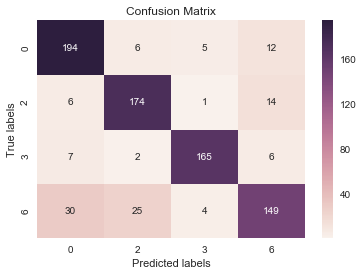

In [160]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Orig_Val_y, CNN_predictions, labels)

Clearly, this model is performing  better than Random forest classifier and SVC but it is still underperforming for class label 6.<br>

We'll save this model in HDF5 format for now so that if the later models does not outperform this one, we can consider this model as the final one.

In [121]:
model.save(f'{PATH}//Models//model-1.h5')

As the model is now downloaded to local computer, it can be deleted from memory.

In [177]:
del model

##### Model 2

Configuration of this second model will be kept almost same as the first one. Two notable changes are that this time `padding` parameter will be kept as `same` and number of output units for intermediate dense layer is now increased to 64 which will increase the number of parameters to 91, 972 as shown in the summary of the model. Increasing the number of parameters will increase model's complexity hence should be able to perform better.

In [19]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (28,28,1), padding = "same", activation = 'relu')) #output: 28 x 28 x 32 
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = 'relu')) #output: 28 x 28 x 32
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 14 x 14 x 32

model.add(Dropout(0.50)) #output: 14 x 14 x 32

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = 'relu')) #output: 14 x 14 x 64
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = 'relu')) #output: 14 x 14 x 64
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 7 x 7 x 64

model.add(Dropout(0.50)) #output: 7 x 7 x 64

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu')) #output: 5 x 5 x 32
model.add(MaxPooling2D(pool_size = (2, 2))) #output: 2 x 2 x 32

model.add(Flatten()) #output: 128
model.add(Dense(units = 64, activation = "relu")) #output: 64
model.add(Dense(units = 4, activation = "softmax")) #output: 4

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer= Adam(lr=0.001), metrics =['accuracy'])

Now, instead of fitting model directly on training set, we'll do some image augmentation via a number of random transformations so that model is able to generalize better and not overfit on the training data. For this, we'll use [Image Data Generator](https://keras.io/preprocessing/image/) class of Keras. This will do real-time data augmentation. In particular, our augmenter will rotate, zoom in/out, shift, shear and flip the data horizontally in random ways. <br>

Also, this time our model will be trained for longer period of time i.e. 40 epochs.
To include the augmenter while training, we'd have to use `fit_generator()` method instead of `fit()`.

In [22]:
epochs = 40 #number of times training data will pass through model
batch_size=64 #number of training samples passed through model at a time

#Image augmenter
aug = ImageDataGenerator(rotation_range=20, zoom_range=(0.9, 1.1),
width_shift_range=0.1, height_shift_range=0.1, shear_range=0.5,
horizontal_flip=True, fill_mode="nearest")

#fitting the model
history = model.fit_generator(aug.flow(Train_x, Train_y, batch_size = batch_size),
validation_data=(Val_x, Val_y), epochs = epochs)

Epoch 1/40
113/113 [==============================] - 52s 459ms/step - loss: 1.0941 - acc: 0.4932 - val_loss: 0.7959 - val_acc: 0.6325
Epoch 2/40
113/113 [==============================] - 48s 424ms/step - loss: 0.8485 - acc: 0.6307 - val_loss: 0.7355 - val_acc: 0.6562
Epoch 3/40
113/113 [==============================] - 46s 404ms/step - loss: 0.7717 - acc: 0.6741 - val_loss: 0.6421 - val_acc: 0.7188
Epoch 4/40
113/113 [==============================] - 45s 401ms/step - loss: 0.7277 - acc: 0.6880 - val_loss: 0.6376 - val_acc: 0.7163
Epoch 5/40
113/113 [==============================] - 47s 412ms/step - loss: 0.6863 - acc: 0.7099 - val_loss: 0.6397 - val_acc: 0.7188
Epoch 6/40
113/113 [==============================] - 48s 423ms/step - loss: 0.6772 - acc: 0.7107 - val_loss: 0.5977 - val_acc: 0.7388
Epoch 7/40
113/113 [==============================] - 46s 403ms/step - loss: 0.6542 - acc: 0.7257 - val_loss: 0.6568 - val_acc: 0.7338
Epoch 8/40
113/113 [==============================] - 4

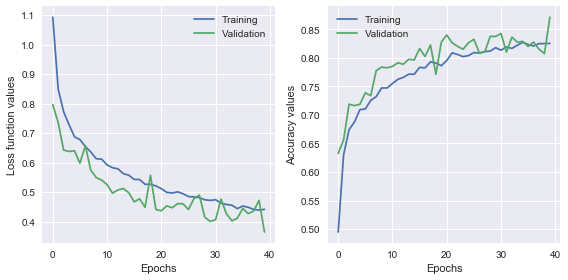

In [25]:
plot_loss_acc(history, 40)

Final validation accuracy for this model is 87.12% which is better than the previous model. Let's just repeat the steps we performed for generating predictions and confusion matrix for the previous model.

In [26]:
predictions = model.predict(Val_x)

In [27]:
#dictionary mapping from indices of output vector to corresponding class labels
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}

#array to hold the predicted labels
CNN_predictions = np.zeros(len(predictions))

#loop through predicted vectors and adding predicted classes to CNN_predictions 
for i in range(len(predictions)):
    
    #get index of maximum element in vector
    arg_max = np.argmax(predictions[i])
    
    #add value of key: arg_max from prediction_dict to CNN_predictions
    CNN_predictions[i] = prediction_dict[arg_max]

In [28]:
Orig_Val_y = Val_y.values.argmax(axis=1)
Orig_Val_y = np.array([prediction_dict[y] for y in Orig_Val_y])

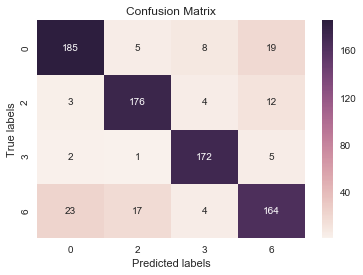

In [31]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Orig_Val_y, CNN_predictions, labels)

In [34]:
print(f"Classification report for CNN classifier: \n{classification_report(Orig_Val_y, CNN_predictions)}")

Classification report for CNN classifier: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       217
           2       0.88      0.90      0.89       195
           3       0.91      0.96      0.93       180
           6       0.82      0.79      0.80       208

   micro avg       0.87      0.87      0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



This model has clearly outperformed all previous classifiers by good margin. Particularly, if we compare the classification report for class label 6, it has increased by almost 10%. <br>

Let's now save the model.

In [ ]:
model.save(f'{PATH}//Models//model-2.h5')

Model 2 has shown good level of performance, but there is no harm in re-training the trained parameters of this model for some more time. If re-trained model does not performs better, we can obviously discard it and generate predictions using previously saved Model 2. <br>

So, let's train the Model 2 on training data for 10 more epochs.

In [35]:
history = model.fit(Train_x, Train_y, batch_size = batch_size,
validation_data=(Val_x, Val_y), epochs = 10)

Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 44s 6ms/step - loss: 0.3612 - acc: 0.8593 - val_loss: 0.3549 - val_acc: 0.8612
Epoch 2/10
7200/7200 [==============================] - 44s 6ms/step - loss: 0.3441 - acc: 0.8608 - val_loss: 0.3391 - val_acc: 0.8700
Epoch 3/10
7200/7200 [==============================] - 44s 6ms/step - loss: 0.3258 - acc: 0.8722 - val_loss: 0.3803 - val_acc: 0.8425
Epoch 4/10
7200/7200 [==============================] - 46s 6ms/step - loss: 0.3296 - acc: 0.8710 - val_loss: 0.3400 - val_acc: 0.8675
Epoch 5/10
7200/7200 [==============================] - 46s 6ms/step - loss: 0.3080 - acc: 0.8812 - val_loss: 0.3224 - val_acc: 0.8712
Epoch 6/10
7200/7200 [==============================] - 45s 6ms/step - loss: 0.3065 - acc: 0.8808 - val_loss: 0.3345 - val_acc: 0.8688
Epoch 7/10
7200/7200 [==============================] - 45s 6ms/step - loss: 0.2984 - acc: 0.8839 - val_loss: 0.3102 - val_acc: 0.8838
Epoch 8/

Well, we have an increase in accuracy of about 1% and 447 seconds that took it to train this model didn't go in vain. We'll call this model as Model 2.2 as it is just more trained version of Model 2. Let's again copy the above cells for prediction and evaluation.

In [37]:
predictions = model.predict(Val_x)

In [38]:
#dictionary mapping from indices of output vector to corresponding class labels
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}

#array to hold the predicted labels
CNN_predictions = np.zeros(len(predictions))

#loop through predicted vectors and adding predicted classes to CNN_predictions 
for i in range(len(predictions)):
    
    #get index of maximum element in vector
    arg_max = np.argmax(predictions[i])
    
    #add value of key: arg_max from prediction_dict to CNN_predictions
    CNN_predictions[i] = prediction_dict[arg_max]

In [39]:
Orig_Val_y = Val_y.values.argmax(axis=1)
Orig_Val_y = np.array([prediction_dict[y] for y in Orig_Val_y])

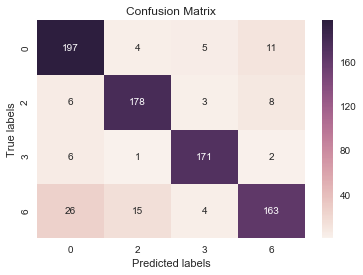

In [40]:
labels = [0, 2, 3, 6]
plot_confusion_matrix(Orig_Val_y, CNN_predictions, labels)

In [46]:
print(f"Classification report for CNN classifier: \n{classification_report(Orig_Val_y, CNN_predictions)}")

Classification report for CNN classifier: 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       217
           2       0.90      0.91      0.91       195
           3       0.93      0.95      0.94       180
           6       0.89      0.78      0.83       208

   micro avg       0.89      0.89      0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



In [42]:
model.save(f'{PATH}//Models//model-2.2.h5')

At this point, we are done with building the classifiers and our final chosen model will be Model 2.2 as it has more generalization as well as prediction power.

In [47]:
del model

### Generating prediction for Test set using Model 2.2

#### Test data loading and pre-processing

Firstly, we'll have to load in the test data and perform the same pre-processing steps that we did for training and validation sets.

In [12]:
with open(f'{PATH}//Data//test_image.pkl', 'rb') as image_file:
    test_images = pickle.load(image_file)

In [13]:
print(f'Number of test samples: {len(test_images)}')

Number of test samples: 2000


In [14]:
#converting the images to numpy array
test_images = np.array(test_images)

In [15]:
print(f'Shape of test images: {test_images.shape}')

Shape of test images: (2000, 784)


In [16]:
#reshaping the image vectors to 2D arrays
test_images = test_images.reshape((-1, 28, 28, 1))
print(f'Shape of test images: {test_images.shape}')

Shape of test images: (2000, 28, 28, 1)


In [17]:
#normalization
test_images = test_images.astype("float32") / 255.0

#### Loading trained model 

Now, let's load in the trained model for generating predictions.

In [18]:
model = load_model(f'{PATH}//Models//model-2.2.h5')

#### Generating predictions and converting them to class labels

In [19]:
test_predictions = model.predict(test_images)

In [20]:
#dictionary mapping from indices of output vector to corresponding class labels
prediction_dict = {0: 0, 1: 2, 2: 3, 3: 6}

#array to hold the predicted labels for test set
CNN_test_predictions = np.zeros(len(test_predictions))

#loop through predicted vectors and adding predicted classes to CNN_predictions 
for i in range(len(test_predictions)):
    
    #get index of maximum element in vector
    arg_max = np.argmax(test_predictions[i])
    
    #add value of key: arg_max from prediction_dict to CNN_predictions
    CNN_test_predictions[i] = prediction_dict[arg_max]

In [21]:
CNN_test_predictions = CNN_test_predictions.astype(int)

#### Plotting the test images alongside there predicted labels
Now, as most of the work is done, let's see how predicted labels and images look. Here, we'll plot 100 randomly selected test images to get a broad view at the predictions.

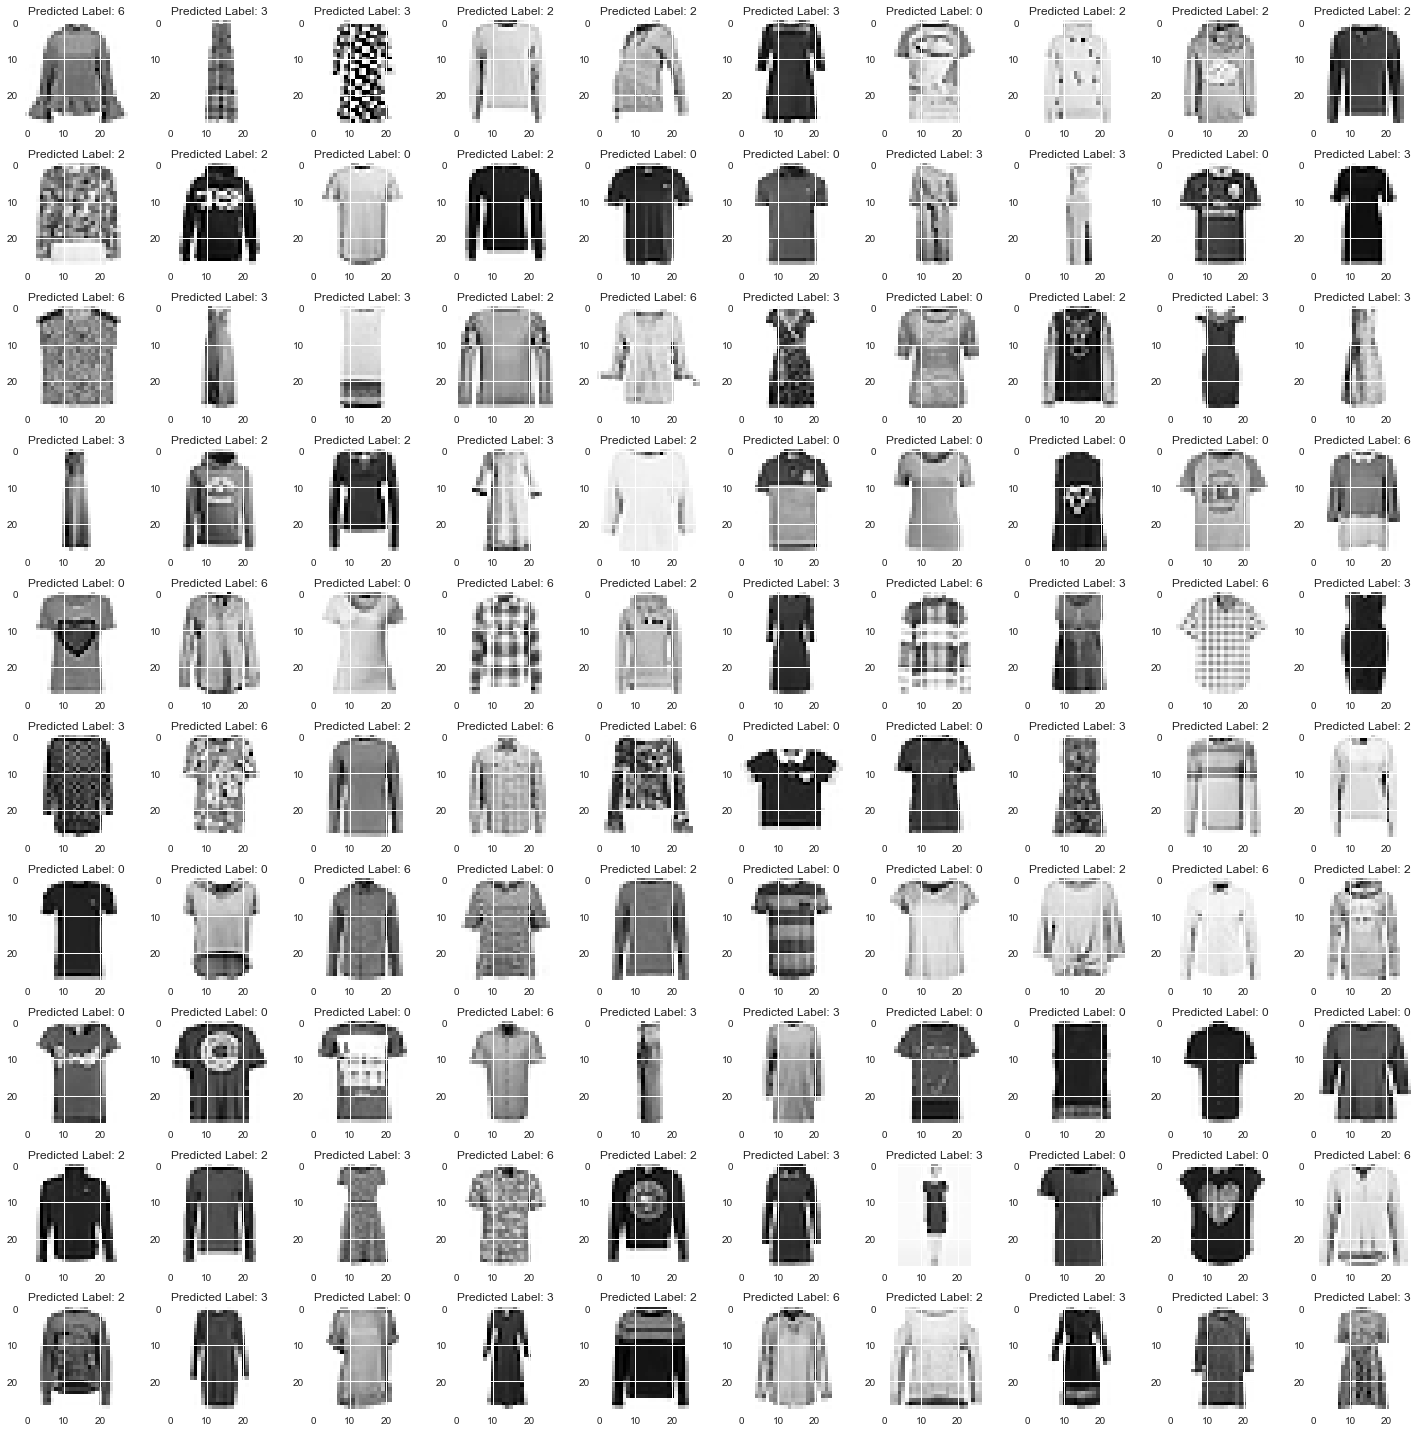

In [22]:
#reloading the test_images
with open(f'{PATH}//Data//test_image.pkl', 'rb') as image_file:
    test_images = np.array(pickle.load(image_file))
    
fig = plt.figure(figsize=(20, 20))

indices = np.random.permutation(test_images.shape[0]) #generating random indices for plotting

#Showing first n_ images from the dataset specified by indices
for i in range(1, 101):
    plt.subplot(10, 10, i)
    plt.imshow(test_images[indices[i]].reshape(28, 28))
    plt.title(f'Predicted Label: {CNN_test_predictions[indices[i]]}') #corresponding predicted label to each of the image

fig.tight_layout()  #for better padding amongst subplots
plt.show()

#### Storing the prediction results in a CSV file

This is the required format of submission:

In [23]:
sample_df = pd.read_csv(f'{PATH}\\Data\\hitkul(sample_submission).csv')

In [24]:
sample_df

,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


Submission:

In [17]:
submission_df = pd.DataFrame({'image_index': np.arange(len(test_images)), 'class': CNN_test_predictions})

In [18]:
submission_df.head(10)

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [19]:
submission_df.to_csv(f'{PATH}\\akshay_aggarwal.csv', index=False)

In [25]:
df = pd.read_csv(f'{PATH}\\akshay_aggarwal.csv')

In [26]:
df.head()

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
